In [1]:
import opendssdirect as dss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# OpenDSS PV system
def PV_attach(num, kVA, pf, Location, Voltage):
    # PV system
    dss.run_command('Redirect D:\OpenDSS_test\PVsystemexample.dss')

    for i in range(num):
        dss.run_command(
            "New PVSystem.PV_" + str(i) + " phases=3 bus1=" + str(Location[i]) + " kVA=" + str(kVA[i]) + " kv=" + str(
                Voltage[i]) + " irrad=1 pmpp=" + str(kVA[i]) + " temperature=25 pf=" + str(pf[i]))
        dss.run_command(
            "~ %cutin=0.1 %cutout=0.1 effcurve=MyEff" + str(i) + " P-tcurve=MyPvsT" + str(i) + " Daily=MyIrrad" + str(
                i) + " Tdaily=Mytemp")

In [3]:
# OpenDSS 34 Bus mod2 run command
def run_command(control, num, kVA, pf, Location, Voltage):
    # Bus System
    dss.run_command('Redirect D:\OpenDSS_test\ieee34Mod2.dss')

    PV_attach(num, kVA, pf, Location, Voltage)

    # Run command
    dss.run_command("Set VoltageBases = '69,24.9,4.16, .48'")
    dss.run_command('CalcVoltageBases')
    dss.run_command('BusCoords IEEE34_BusXY.csv')

    # Monitor PV & L1
    for i in range(num):
        dss.run_command(
            "New monitor.PV" + str(i) + "_power element=PVSystem.PV_" + str(i) + " terminal=1 mode=1 ppolar=no")
    dss.run_command("New monitor.L1_power element=line.L1 terminal=1 mode=1 ppolar=no")

    # Energymeter L1
    dss.run_command("New energymeter.M1 element = Transformer.SubXF terminal = 1")

    # Check Set mode
    if control == 0:
        dss.run_command('set mode=daily')
        dss.run_command('set stepsize=1h')
        dss.run_command('set number=24')
    else:
        dss.run_command('set mode=snapshot')

        # Transformer tap setting
        dss.run_command('Transformer.reg1a.wdg=2 Tap=(0.00625  12  * 1 +)')     # Tap 12
        dss.run_command('Transformer.reg1b.wdg=2 Tap=(0.00625   5 * 1 +)')      # Tap 5
        dss.run_command('Transformer.reg1c.wdg=2 Tap=(0.00625   5  * 1 +)')     # Tap 5
        dss.run_command('Transformer.reg2a.wdg=2 Tap=(0.00625  13 * 1 +)')      # Tap 13
        dss.run_command('Transformer.reg2b.wdg=2 Tap=(0.00625  11 * 1 +)')      # Tap 11
        dss.run_command('Transformer.reg2c.wdg=2 Tap=(0.00625  12 * 1 +)')      # Tap 12

        dss.run_command('set controlmode = off')
        # dss.run_command('set controlmode = static')

    # Solve
    dss.run_command('solve')

In [4]:
# To plot PV output
def plot_PV_power(num):
    # 해당 Part는 PV 출력 곡선을 작성하는 부분
    # Export PV monitor results
    for i in range(num):
        dss.run_command("Export monitors PV" + str(i) + "_power")

    # Export L1_power monitor result
    dss.run_command("Export monitors L1_power")

    for i in range(5):
        # Getting PV monitor data from csv file
        df = pd.read_csv("D:\OpenDSS_test\ieee34-2_Mon_pv" + str(i) + "_power_1.csv")
        df.columns = ['hour', 'sec', 'P1', 'Q1', 'P2', 'Q2', 'P3', 'Q3', 'P4', 'Q4']

        # Plotting PV monitor data
        plt.figure(i + 1)
        plt.subplot(2, 3, 1)
        plt.plot(df.hour, -df.P1)
        plt.subplot(2, 3, 2)
        plt.plot(df.hour, -df.P2)
        plt.subplot(2, 3, 3)
        plt.plot(df.hour, -df.P3)
        plt.subplot(2, 3, 4)
        plt.plot(df.hour, -df.Q1)
        plt.subplot(2, 3, 5)
        plt.plot(df.hour, -df.Q2)
        plt.subplot(2, 3, 6)
        plt.plot(df.hour, -df.Q3)

        # Getting L1_power monitor data from csv file
    df = pd.read_csv("D:\OpenDSS_test\ieee34-2_Mon_l1_power_1.csv")
    df.columns = ['hour', 'sec', 'P1', 'Q1', 'P2', 'Q2', 'P3', 'Q3']

    # Plotting L1_power monitor data
    plt.figure(6)
    plt.plot(df.hour, df.P1, df.hour, df.P2, df.hour, df.P3)
    plt.show()

In [5]:
# Get sensitivity matrix by inversing Jacobian
def get_inv_J():
    # Export admittance matrix Y and voltages
    dss.run_command("Export Y")
    dss.run_command("Export Voltages")

    # Getting admittance matrix data from csv file
    # 먼저 문자열로 받고 Dummy data를 포함하는 첫번째 행 제거
    array_Y = np.loadtxt("D:\OpenDSS_test\ieee34-2_EXP_Y.CSV", delimiter=',', dtype=str, skiprows=1)

    # 해당 문자열에서 bus를 나타나는 1열을 제거
    array_Y = array_Y[:, 1:]

    # 행의 크기를 측정
    row_len = array_Y.shape[0]

    # (행의 크기)^2 빈 배열 선언 -> 변환된 Admittance
    new_Y = np.empty((row_len, row_len), dtype=complex)

    # For문을 사용해서 복소수 형태로 변환 후 저장
    for i in range(row_len):
        for j in range(row_len):
            real_num = float(array_Y[i, j * 2].replace(" ", ""))
            im_num = array_Y[i, j * 2 + 1]
            im_num = float(im_num[4:].replace(" ", ""))
            new_Y[i, j] = complex(real_num, im_num)

    # Getting Voltage magnitude and angle
    # 먼저 문자열로 받고 첫번째 행 제거
    array_V = np.loadtxt("D:\OpenDSS_test\ieee34-2_EXP_VOLTAGES.CSV", delimiter=',', dtype=str, skiprows=1)

    # 해당 문자열에서 bus를 나타나는 1열을 제거
    array_V = array_V[:, 3:-1]

    # 행의 크기를 측정
    row_len_V = array_V.shape[0]

    # 빈 배열에 append
    new_V = []
    new_angle = []

    # For문을 사용해서 값을 할당
    for i in range(row_len_V):
        for j in range(3):
            if float(array_V[i, j * 4].replace(" ", "")) != 0:
                new_V.append(float(array_V[i, j * 4].replace(" ", "")))
                new_angle.append(float(array_V[i, j * 4 + 1].replace(" ", "")))

    # J1에서 J4를 빈 배열로 선언
    new_J_1 = np.empty((row_len, row_len), dtype=float)
    new_J_2 = np.empty((row_len, row_len), dtype=float)
    new_J_3 = np.empty((row_len, row_len), dtype=float)
    new_J_4 = np.empty((row_len, row_len), dtype=float)

    # For문을 사용해서 값을 할당
    for k in range(row_len):
        for n in range(row_len):
            if k == n:
                sum_1 = 0
                sum_2 = 0
                sum_3 = 0
                sum_4 = 0
                for a in range(row_len):
                    sum_2 += new_V[a] * np.absolute(new_Y[k, a]) * np.cos(
                        (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))
                    sum_4 += new_V[a] * np.absolute(new_Y[k, a]) * np.sin(
                        (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))

                    if a != k:
                        sum_1 += new_V[a] * np.absolute(new_Y[k, a]) * np.sin(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))
                        sum_3 += new_V[a] * np.absolute(new_Y[k, a]) * np.cos(
                            (new_angle[k] - new_angle[a]) * np.pi / 180 - np.angle(new_Y[k, a]))

                new_J_1[k, k] = -new_V[k] * sum_1
                new_J_2[k, k] = new_V[k] * np.absolute(new_Y[k, k]) * np.cos(np.angle(new_Y[k, k])) + sum_2
                new_J_3[k, k] = new_V[k] * sum_3
                new_J_4[k, k] = -new_V[k] * np.absolute(new_Y[k, k]) * np.sin(np.angle(new_Y[k, k])) + sum_4

            else:
                new_J_1[k, n] = new_V[k] * new_V[n] * np.absolute(new_Y[k, n]) * np.sin(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_2[k, n] = new_V[k] * np.absolute(new_Y[k, n]) * np.cos(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_3[k, n] = -new_V[k] * new_V[n] * np.absolute(new_Y[k, n]) * np.cos(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))
                new_J_4[k, n] = new_V[k] * np.absolute(new_Y[k, n]) * np.sin(
                    (new_angle[k] - new_angle[n]) * np.pi / 180 - np.angle(new_Y[k, n]))

    # Jacobian matrix
    J = np.block([[new_J_1, new_J_2], [new_J_3, new_J_4]])

    # Sensitivity matrix
    Ans = np.linalg.inv(J)
    return Ans[row_len:, :]

In [6]:
# 34 Bus Diagram을 출력
def plot_34bus(Location):
    plt.title("IEEE 34 bus system")
    array_XY = np.loadtxt("D:\OpenDSS_test\IEEE34_BusXY.csv", delimiter=',', dtype=str)
    row_len = array_XY.shape[0]
    Line_property1 = np.loadtxt('D:\OpenDSS_test\ieee34Mod1.dss', delimiter=',', dtype=str, skiprows=18, max_rows=25)
    Line_property2 = np.loadtxt('D:\OpenDSS_test\ieee34Mod1.dss', delimiter=',', dtype=str, skiprows=49, max_rows=2)
    Line_property3 = np.loadtxt('D:\OpenDSS_test\ieee34Mod1.dss', delimiter=',', dtype=str, skiprows=52, max_rows=5)
    Line_property = np.concatenate((Line_property1, Line_property2, Line_property3), axis=0)

    x = np.empty(row_len, dtype=int)
    y = np.empty(row_len, dtype=int)

    for i in range(row_len):
        x[i] = int(array_XY[i, 1])
        y[i] = int(array_XY[i, 2])
        plt.text(x[i], y[i], array_XY[i, 0], fontsize=8)
    plt.plot(x, y, 'o')

    for i in range(len(Line_property)):
        # 선을 그을 시작점 Bus1의 위치를 확인
        line = Line_property[i]
        a = np.char.find(line, "Bus1=")
        b = np.char.find(line, "Bus2=")

        # 두가지를 확인할 것 1.먼저 Bus가 r을 포함하는지 2. 단상인지 삼상인지 -클리어- 해결
        if line[a + 8] == 'r':
            x = line[a + 5: a + 9]
        else:
            x = line[a + 5: a + 8]

        y = line[b + 5: b + 8]

        for j in range(row_len):
            if x == array_XY[j, 0]:
                send = j
        for j in range(row_len):
            if y == array_XY[j, 0]:
                rec = j

        if line[a + 11] != '2' and line[a + 8] != 'r':
            plt.plot([int(array_XY[send, 1]), int(array_XY[rec, 1])], [int(array_XY[send, 2]), int(array_XY[rec, 2])],
                     color='Black', linewidth=1)
        else:
            plt.plot([int(array_XY[send, 1]), int(array_XY[rec, 1])], [int(array_XY[send, 2]), int(array_XY[rec, 2])],
                     color='Black', linewidth=3)

    for i in range(len(Location)):
        for j in range(row_len):
            if array_XY[j][0] == str(Location[i]):
                x = int(array_XY[j][1])
                y = int(array_XY[j][2])
                plt.plot([x - 30, x + 30], [y + 30, y + 30], color='Blue', linewidth=3)
                plt.plot([x - 30, x + 30], [y - 30, y - 30], color='Blue', linewidth=3)
                plt.plot([x - 30, x - 30], [y - 30, y + 30], color='Blue', linewidth=3)
                plt.plot([x + 30, x + 30], [y - 30, y + 30], color='Blue', linewidth=3)
                plt.text(x + 50, y + 50, "PV installed", fontsize=8)
                continue

    plt.plot([-300, 0], [0, 0], color='Green', linewidth=3)
    plt.plot([4000, 4700], [-400, -400], color='Green', linewidth=3)

    plt.plot([1600, 2100], [0, 0], color='Yellow', linewidth=3)
    plt.plot([4000, 4000], [-900, -600], color='Yellow', linewidth=3)

    plt.show()

In [7]:
# Voltage 이상을 확인 및 문제 있는 Bus voltage 출력
def L_N_voltage_profile_check():
    # PU voltage and Node name
    array_V = dss.Circuit.AllBusMagPu()
    array_name = dss.Circuit.AllNodeNames()

    # Output to return
    result = []

    for i in range(len(array_V)):
        if float(array_V[i]) > 1.05:
            # 현재 출력 필요 X - print("OverVoltage occur in "+ str(array_name[i]) +"\t\t\t : "+ str(array_V[i]) + "p.u.")
            result.append((i, 1))
        elif float(array_V[i]) < 0.95:
            # 현재 출력 필요 X -  print("UnderVoltage occur in " + str(array_name[i]) + "\t\t\t : " + str(array_V[i]) + "p.u.")
            result.append((i, 0))

    return result

In [8]:
# LN voltage profile을 plot하는 함수
def plot_L_N_voltage_profile():
    x = dss.Circuit.AllNodeDistances()
    y = dss.Circuit.AllBusMagPu()
    z = dss.Circuit.AllNodeNames()

    plt.plot(x, y, 'o')

    # Upper Bound / Lower Bound
    plt.plot([0, max(x)], [1.05, 1.05], color='Red', linewidth=3)
    plt.plot([0, max(x)], [0.95, 0.95], color='Red', linewidth=3)

    # for i in range(len(z)):
        # plt.text(x[i], y[i], z[i], fontsize=5)

    plt.show()

In [9]:
# control = 0 -> mode = daily / control = 1 -> mode = snapshot, control mode = off
control = 1

# Number of PV
num = 5

# PV Location and Voltage
Location = [890, 848, 840, 854, 816]
Voltage = [4.16, 24.9, 24.9, 24.9, 24.9]

# PV rating
kVA = [120, 10, 1, 1, 1]

# Powerfactor
pf = [1, 1, 1, 1, 1]

run_command(control, num, kVA, pf, Location, Voltage)

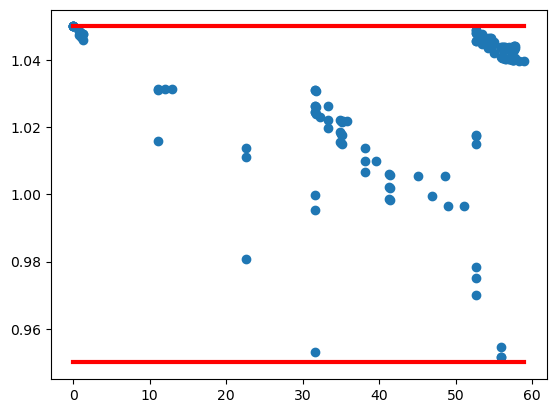

In [10]:
plot_L_N_voltage_profile()

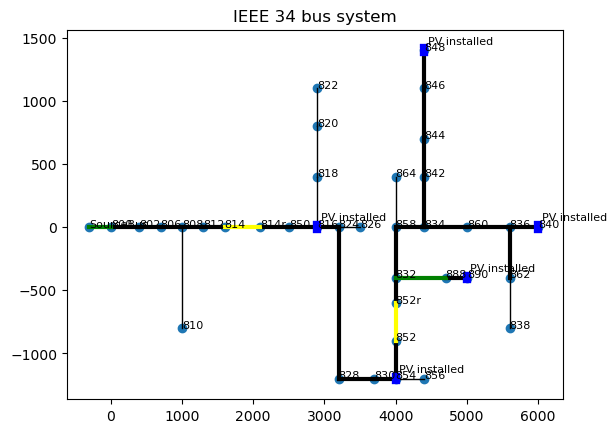

In [11]:
plot_34bus(Location)